# Regime-Dependent Factor Betas

In [64]:
from datetime import datetime
from hmmlearn.hmm import GaussianHMM
import pandas as pd
import numpy as np
import os
from scipy.linalg import block_diag
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
warnings.simplefilter('ignore')

fldr = os.path.abspath(os.path.join(os.getcwd(), '..'))
start_dt = datetime(1926, 12, 31) 
end_dt = datetime(2020, 3, 31)
freq = 'W'
aesthetic_labels = {'mktrf': 'Market - Rf', 'smb': 'SmB', 'hml': 'HmL'}

# Fama-French factors
rt_ff = pd.read_pickle(f'{fldr}/data/ff.pkl')
rt_ff = rt_ff.add(1).groupby(pd.Grouper(freq=freq)).prod().sub(1)
rt_ff = rt_ff.loc[start_dt:end_dt]

# Stock returns (Con Edison, permno: 11404)
# General-Electric 12060
# Coca-cola 11308
rt = pd.read_pickle(f'{fldr}/data/rt_sp.pkl').loc[start_dt:end_dt, 11308]
rt = rt.add(1).groupby(pd.Grouper(freq=freq)).prod().sub(1)
er = rt - rt_ff['rf']

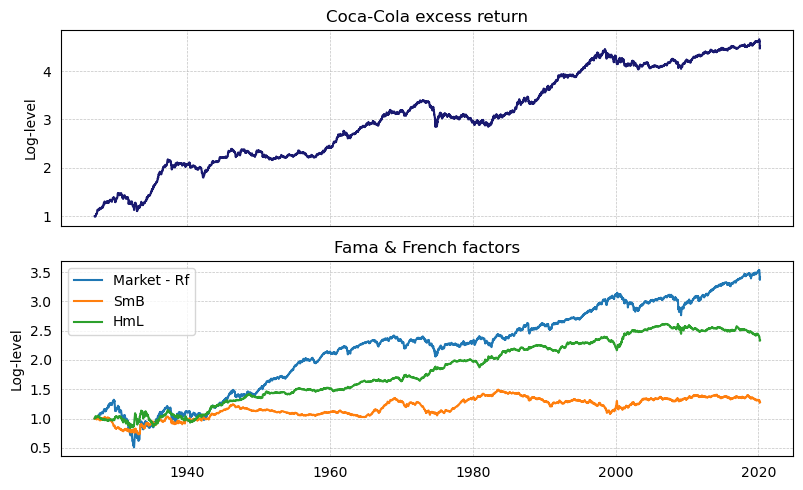

In [27]:
# Visualizing the dataset
fig, axs = plt.subplots(figsize=(8, 5), nrows=2, sharex=True)
axs[0].plot(er.add(1).cumprod().mul(10).apply(np.log10), c='midnightblue')
axs[1].plot(rt_ff[['mktrf', 'smb', 'hml']].add(1).cumprod().mul(10).apply(np.log10))
for i in range(2):
    axs[i].grid(ls='--', lw=.5, alpha=.75, zorder=-25)
    axs[i].set_ylabel('Log-level')
    axs[i].tick_params(bottom=False, left=False)

axs[0].set_title('Coca-Cola excess return')
axs[1].set_title('Fama & French factors')
axs[1].legend(['Market - Rf', 'SmB', 'HmL'])
plt.tight_layout()

In [67]:
# Full-sample OLS
endog = er.dropna()
exog = rt_ff[['mktrf', 'smb', 'hml']]
exog.rename(aesthetic_labels, axis=1, inplace=True)
exog = sm.add_constant(exog)
model = sm.OLS(endog, exog)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     704.2
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:54:31   Log-Likelihood:                 10915.
No. Observations:                4866   AIC:                        -2.182e+04
Df Residuals:                    4862   BIC:                        -2.180e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0014      0.000      3.731      

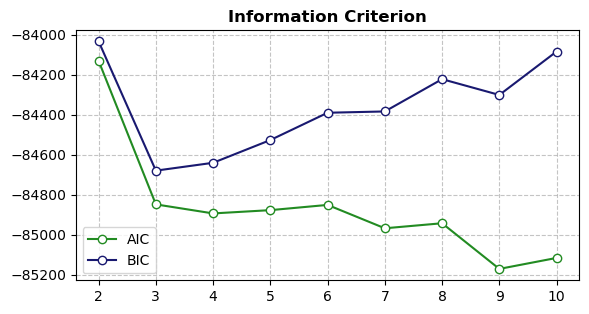

In [42]:
trn = rt_ff[['mktrf', 'smb', 'hml']]  # Training set
X = trn.values

states_to_try = range(2, 11)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
for n in states_to_try:
    mdl = GaussianHMM(n_components=n, covariance_type="diag", n_iter=100, min_covar=1e-3, algorithm='viterbi', random_state=0, tol=.75)
    mdl.fit(X)
    bic[n] = mdl.bic(X)
    aic[n] = mdl.aic(X)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.25), sharex=True, sharey=False)
plot_map = {'AIC': (aic, 'forestgreen'), 'BIC': (bic, 'midnightblue')}

for i, label in enumerate(plot_map):
    ax.plot(plot_map[label][0], color=plot_map[label][1], marker='o', mfc='white')
    ax.grid(ls='--', alpha=.75)

ax.set_title('Information Criterion', weight='bold')
ax.legend(['AIC', 'BIC'])

In [72]:
# Model fitting
trn = rt_ff[['mktrf', 'smb', 'hml']]  # Training set
m = 3  # Number of regimes
k = trn.shape[1]  # Number of factors

model = GaussianHMM(n_components=m, covariance_type="diag", n_iter=1000, min_covar=1e-10, algorithm='viterbi', random_state=0)
model.fit(trn)
emission_prob = pd.DataFrame(model.predict_proba(trn), index=trn.index)

# Results tables
cols = pd.MultiIndex.from_tuples([('State-dependent means', asthetic_labels[x]) for x in trn.columns])
table_means = pd.DataFrame(model.means_, columns=cols)
table_means.index.name = 'Hidden State'
display(table_means.mul(52).apply(lambda x: x.map('{:.2%}'.format)))

print('\n')
cols = pd.MultiIndex.from_tuples([('State-dependent volatilities', asthetic_labels[x]) for x in trn.columns])
table_vols = pd.DataFrame([np.diag(model.covars_[i]) for i in range(m)], columns=cols).apply(np.sqrt)
table_vols.index.name = 'Hidden State'
display(table_vols.mul(np.sqrt(52)).apply(lambda x: x.map('{:.2%}'.format)))

State-dependent means                
                       Market - Rf     SmB     HmL
Hidden State                                      
0                           16.77%   3.67%   0.99%
1                          -19.12%  -1.04%  15.35%
2                          -11.18%  -5.14%   8.86%

State-dependent volatilities                
                              Market - Rf     SmB     HmL
Hidden State                                             
0                                  10.29%   6.00%   5.83%
1                                  49.85%  24.84%  30.97%
2                                  20.66%  10.50%  11.98%

## Plot of con ed with shades

In [24]:
M = block_diag(*[Z] * m)
delta = block_diag(*[er.values.reshape(-1, 1)] * m)
Omega = np.diag(emission_prob.values.flatten('F'))
I = np.concatenate([np.eye(k)] * m, axis=1)
Theta = I @ np.linalg.inv(M.T @ Omega @ M) @ M.T @ Omega @ delta

In [25]:
Theta

array([[ 0.74916849,  0.4498543 ,  0.67278284,  0.7119609 ],
       [-0.23505801, -0.11400481, -0.24762361, -0.16590549],
       [-0.29538525, -0.27564467, -0.06911465, -0.07420874]])